In [28]:
import pandas as pd
from sqlalchemy import create_engine, text, inspect
from pathlib import Path

# 连接到数据库
db_path = Path("../../input_database.db").resolve()
engine = create_engine(f"sqlite:///{db_path}", echo=False)

# 获取项目列表
with engine.connect() as conn:
    projects = pd.read_sql("SELECT project_id, project_name FROM projects ORDER BY project_id", conn)
    
print("数据库中的项目：")
print(projects)
print("\n" + "="*80)


数据库中的项目：
   project_id project_name
0           1        Rapla



In [29]:
project_id = 1  # 我们只有1
solution_table_name = f"solution_schedule_{project_id}"

In [30]:
# 查看所有可用的版本ID
inspector = inspect(engine)
if solution_table_name in inspector.get_table_names():
    columns = [col['name'] for col in inspector.get_columns(solution_table_name)]
    if 'version_id' in columns:
        with engine.connect() as conn:
            versions_query = f'''
                SELECT DISTINCT version_id, COUNT(*) as count 
                FROM "{solution_table_name}" 
                GROUP BY version_id 
                ORDER BY version_id
            '''
            versions_df = pd.read_sql(versions_query, conn)
            print("可用的版本ID：")
            print(versions_df)
            print("\n提示：使用 print_solution_table(version_id=数字) 来查询特定版本")
            print("例如：print_solution_table(version_id=1)")
    else:
        print("该表没有 version_id 列")
else:
    print(f"表 {solution_table_name} 不存在")


可用的版本ID：
   version_id  count
0           1     25
1           2     25
2           3     25
3           4     25

提示：使用 print_solution_table(version_id=数字) 来查询特定版本
例如：print_solution_table(version_id=1)


In [31]:
# 1. 查询 solution_table (solution_schedule_{project_id})

def print_solution_table(version_id=None, engine=engine):
    """
    查询并显示 solution_table 的数据
    
    参数:
        version_id: 如果为 None，则查询最新版本（或所有数据如果没有version_id列）
                   如果指定了version_id，则查询该特定版本
        engine: 数据库引擎
    """
    inspector = inspect(engine)
    if solution_table_name in inspector.get_table_names():
        with engine.connect() as conn:
            # 检查是否有 version_id 列
            columns = [col['name'] for col in inspector.get_columns(solution_table_name)]
            if 'version_id' in columns:
                if version_id is None:
                    # 查询最新版本
                    query = f'''
                        SELECT * FROM "{solution_table_name}"
                        WHERE version_id IS NULL 
                           OR version_id = (SELECT MAX(version_id) FROM "{solution_table_name}" WHERE version_id IS NOT NULL)
                    '''
                else:
                    # 查询特定版本
                    query = f'''
                        SELECT * FROM "{solution_table_name}"
                        WHERE version_id = {version_id}
                    '''
            else:
                # 没有version_id列，查询所有数据
                query = f'SELECT * FROM "{solution_table_name}"'
            
            solution_df = pd.read_sql(query, conn)
        
        print(f"\n【Solution Table】: {solution_table_name}")
        if version_id is not None:
            print(f"查询版本: {version_id}")
        else:
            print("查询版本: 最新版本")
        print(f"总行数: {len(solution_df)}")
        print(f"列数: {len(solution_df.columns)}")
        print("\n列名:", list(solution_df.columns))
        print("\n前10行数据：")
        print(solution_df.head(10))
        print("\n数据形状:", solution_df.shape)
        print("\n" + "="*80)
        return solution_df
    else:
        print(f"\n【Solution Table】: {solution_table_name} 不存在")
        print("="*80)
        return None


In [ ]:
# 查询 optimization_versions 表中的 objective_value
def print_objective_values(project_id=1, engine=engine):
    """
    查询并显示所有版本的 objective_value 数据
    
    参数:
        project_id: 项目ID（默认1）
        engine: 数据库引擎
    """
    versions_table_name = f"optimization_versions_{project_id}"
    
    inspector = inspect(engine)
    table_names = inspector.get_table_names()
    
    if versions_table_name in table_names:
        with engine.connect() as conn:
            query = f'''
                SELECT version_id, version_number, objective_value, status, 
                       project_finish_time, num_orders, project_start_datetime
                FROM "{versions_table_name}"
                ORDER BY version_id
            '''
            obj_df = pd.read_sql(text(query), conn)
        
        print(f"\n【Objective Values】: {versions_table_name}")
        print(f"总版本数: {len(obj_df)}")
        print("\n所有版本的 objective_value：")
        print(obj_df.to_string(index=False))
        
        if not obj_df.empty:
            print(f"\n统计信息：")
            print(f"  最小 objective_value: {obj_df['objective_value'].min():.2f}")
            print(f"  最大 objective_value: {obj_df['objective_value'].max():.2f}")
            print(f"  平均 objective_value: {obj_df['objective_value'].mean():.2f}")
            print(f"  最新版本 (version_id={obj_df['version_id'].max()}): objective_value = {obj_df.loc[obj_df['version_id'].idxmax(), 'objective_value']:.2f}")
        
        print("\n" + "="*80)
        return obj_df
    else:
        print(f"\n【Objective Values】: {versions_table_name} 表不存在")
        print("="*80)
        return None

# 执行查询
objective_df = print_objective_values(project_id= 1)



OperationalError: (sqlite3.OperationalError) no such column: project_finish_time
[SQL: 
                SELECT version_id, version_number, objective_value, status, 
                       project_finish_time, num_orders, project_start_datetime
                FROM "optimization_versions_1"
                ORDER BY version_id
            ]
(Background on this error at: https://sqlalche.me/e/20/e3q8)

In [33]:
solution_df_0 = print_solution_table(version_id=1)


【Solution Table】: solution_schedule_1
查询版本: 1
总行数: 25
列数: 15

列名: ['Module_ID', 'Module_Index', 'Installation_Start', 'Installation_Finish', 'Installation_Duration', 'Arrival_Time', 'Production_Start', 'Production_Duration', 'Factory_Wait_Start', 'Factory_Wait_Duration', 'Onsite_Wait_Start', 'Onsite_Wait_Duration', 'Transport_Start', 'Transport_Duration', 'version_id']

前10行数据：
  Module_ID  Module_Index  Installation_Start  Installation_Finish  \
0  VS-02-31             1                  14                   16   
1  VS-02-22             2                   5                    8   
2  VS-02-21             3                   5                    5   
3   VS-01-2             4                  30                   32   
4   VS-01-8             5                  17                   19   
5  VS-02-29             6                   6                    9   
6  VS-02-92             7                  10                   10   
7   VS-01-3             8                  13             

In [34]:
solution_df_1 = print_solution_table(version_id=2)


【Solution Table】: solution_schedule_1
查询版本: 2
总行数: 25
列数: 15

列名: ['Module_ID', 'Module_Index', 'Installation_Start', 'Installation_Finish', 'Installation_Duration', 'Arrival_Time', 'Production_Start', 'Production_Duration', 'Factory_Wait_Start', 'Factory_Wait_Duration', 'Onsite_Wait_Start', 'Onsite_Wait_Duration', 'Transport_Start', 'Transport_Duration', 'version_id']

前10行数据：
  Module_ID  Module_Index  Installation_Start  Installation_Finish  \
0  VS-02-31             1                   5                    7   
1  VS-02-22             2                   5                    8   
2  VS-02-21             3                   8                    8   
3   VS-01-2             4                  32                   34   
4   VS-01-8             5                  37                   39   
5  VS-02-29             6                   9                   12   
6  VS-02-92             7                  13                   13   
7   VS-01-3             8                  13             

In [35]:
solution_df_2 = print_solution_table(version_id=3)


【Solution Table】: solution_schedule_1
查询版本: 3
总行数: 25
列数: 15

列名: ['Module_ID', 'Module_Index', 'Installation_Start', 'Installation_Finish', 'Installation_Duration', 'Arrival_Time', 'Production_Start', 'Production_Duration', 'Factory_Wait_Start', 'Factory_Wait_Duration', 'Onsite_Wait_Start', 'Onsite_Wait_Duration', 'Transport_Start', 'Transport_Duration', 'version_id']

前10行数据：
  Module_ID  Module_Index  Installation_Start  Installation_Finish  \
0  VS-02-31             1                   5                    7   
1  VS-02-22             2                   5                    8   
2  VS-02-21             3                   8                    8   
3   VS-01-2             4                  44                   46   
4   VS-01-8             5                  41                   43   
5  VS-02-29             6                   9                   12   
6  VS-02-92             7                  13                   13   
7   VS-01-3             8                  13             

In [36]:
solution_df_3 = print_solution_table(version_id=4)


【Solution Table】: solution_schedule_1
查询版本: 4
总行数: 25
列数: 15

列名: ['Module_ID', 'Module_Index', 'Installation_Start', 'Installation_Finish', 'Installation_Duration', 'Arrival_Time', 'Production_Start', 'Production_Duration', 'Factory_Wait_Start', 'Factory_Wait_Duration', 'Onsite_Wait_Start', 'Onsite_Wait_Duration', 'Transport_Start', 'Transport_Duration', 'version_id']

前10行数据：
  Module_ID  Module_Index  Installation_Start  Installation_Finish  \
0  VS-02-31             1                   5                    7   
1  VS-02-22             2                   5                    8   
2  VS-02-21             3                   8                    8   
3   VS-01-2             4                  41                   43   
4   VS-01-8             5                  29                   31   
5  VS-02-29             6                   9                   12   
6  VS-02-92             7                  13                   13   
7   VS-01-3             8                  13             

In [37]:
# 2. 查询 summary_table (optimization_summary_{project_id})
summary_table_name = f"optimization_summary_{project_id}"

def print_summary_table(version_id=None, engine=engine):
    inspector = inspect(engine)
    if summary_table_name in inspector.get_table_names():
        with engine.connect() as conn:
            columns = [col['name'] for col in inspector.get_columns(summary_table_name)]
            if 'version_id' in columns:
                if version_id is None:
                    # 查询最新版本
                    query = f'''
                        SELECT * FROM "{summary_table_name}"
                        WHERE version_id IS NULL 
                        OR version_id = (SELECT MAX(version_id) FROM "{summary_table_name}" WHERE version_id IS NOT NULL)
                    '''
                else:
                    # 查询特定版本
                    query = f'''
                        SELECT * FROM "{summary_table_name}"
                        WHERE version_id = {version_id}
                    '''
            else:
                query = f'SELECT * FROM "{summary_table_name}"'
            
            summary_df = pd.read_sql(query, conn)
    
    print(f"\n【Summary Table】: {summary_table_name}")
    print(f"总行数: {len(summary_df)}")
    print(f"列数: {len(summary_df.columns)}")
    print("\n列名:", list(summary_df.columns))
    print("\n所有数据：")
    print(summary_df)
    print("\n" + "="*80)



In [38]:
summary_df_0 = print_summary_table(version_id=1)


【Summary Table】: optimization_summary_1
总行数: 1
列数: 7

列名: ['project_id', 'version_id', 'objective_value', 'status', 'project_finish_time', 'num_orders', 'order_times']

所有数据：
   project_id  version_id  objective_value  status  project_finish_time  \
0           1           1            32.05       2                   44   

   num_orders                                  order_times  
0          15  5,10,13,16,19,20,23,26,27,29,30,33,34,36,40  



In [39]:
summary_df_1 = print_summary_table(version_id=2)


【Summary Table】: optimization_summary_1
总行数: 1
列数: 7

列名: ['project_id', 'version_id', 'objective_value', 'status', 'project_finish_time', 'num_orders', 'order_times']

所有数据：
   project_id  version_id  objective_value  status  project_finish_time  \
0           1           2            33.45       2                   47   

   num_orders                              order_times  
0          14  5,8,13,16,19,22,26,29,32,34,36,37,40,45  



In [40]:
summary_df_2 = print_summary_table(version_id=3)


【Summary Table】: optimization_summary_1
总行数: 1
列数: 7

列名: ['project_id', 'version_id', 'objective_value', 'status', 'project_finish_time', 'num_orders', 'order_times']

所有数据：
   project_id  version_id  objective_value  status  project_finish_time  \
0           1           3            34.85       2                   47   

   num_orders                                    order_times  
0          16  5,8,13,16,19,22,23,26,30,32,33,36,37,40,41,44  



In [41]:
summary_df_3 = print_summary_table(version_id=4)


【Summary Table】: optimization_summary_1
总行数: 1
列数: 7

列名: ['project_id', 'version_id', 'objective_value', 'status', 'project_finish_time', 'num_orders', 'order_times']

所有数据：
   project_id  version_id  objective_value  status  project_finish_time  \
0           1           4            39.05       2                   53   

   num_orders                                        order_times  
0          18  5,8,13,16,19,22,29,30,32,35,39,40,41,43,44,45,...  



In [42]:
# 3. 查询 delay_update_records (delay_updates_{project_id})
delay_table_name = f"delay_updates_{project_id}"

if delay_table_name in inspector.get_table_names():
    with engine.connect() as conn:
        delay_df = pd.read_sql(f'SELECT * FROM "{delay_table_name}"', conn)
    
    print(f"\n【Delay Update Records】: {delay_table_name}")
    print(f"总行数: {len(delay_df)}")
    print(f"列数: {len(delay_df.columns)}")
    print("\n列名:", list(delay_df.columns))
    print("\n所有延迟记录：")
    print(delay_df)
    print("\n" + "="*80)
else:
    print(f"\n【Delay Update Records】: {delay_table_name} 不存在")
    print("="*80)



【Delay Update Records】: delay_updates_1
总行数: 6
列数: 10

列名: ['delay_id', 'module_id', 'delay_type', 'phase', 'delay_hours', 'detected_at_time', 'detected_at_datetime', 'reason', 'created_at', 'version_id']

所有延迟记录：
   delay_id module_id          delay_type         phase  delay_hours  \
0         1  VS-02-21  DURATION_EXTENSION   FABRICATION          3.0   
1         2  VS-02-29  START_POSTPONEMENT     TRANSPORT          2.0   
2         3  VS-02-93  DURATION_EXTENSION  INSTALLATION          6.0   
3         4  VS-02-58  START_POSTPONEMENT   FABRICATION          5.0   
4         5   PS-01-4  START_POSTPONEMENT  INSTALLATION         10.0   
5         6  KSS-02-1  DURATION_EXTENSION  INSTALLATION          7.0   

   detected_at_time detected_at_datetime reason           created_at  \
0                 1  2026-01-18 11:07:36   None  2026-01-18 10:07:38   
1                 1  2026-01-18 11:07:40   None  2026-01-18 10:07:46   
2                 1  2026-01-18 13:07:41   None  2026-01-18 12:0

In [13]:
# 可复用的函数：从 solution_df 绘制完整的 Gantt 图（包含所有阶段）
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D


def plot_gantt_from_solution_df(df, sort_by="Production_Start", ascending=True, ax=None):
    """从给定的 solution DataFrame 绘制完整的 Gantt 图，显示所有阶段。
    
    参数
    ------
    df : pd.DataFrame
        包含所有时间阶段列的 DataFrame（直接从数据库读取的 solution_df）
    sort_by : str
        排序列名，默认 "Installation_Start"
    ascending : bool
        排序方向，默认 False（降序）
    ax : matplotlib.axes.Axes or None
        可选的坐标轴对象
        
    返回
    ------
    final_time : float or int
        最终完工时间
    ax : matplotlib.axes.Axes
        绘图使用的坐标轴对象
    """
    # 直接读取df的列
    required_cols = ['Module_ID', 'Production_Start', 'Production_Duration',
                     'Factory_Wait_Start', 'Factory_Wait_Duration',
                     'Transport_Start', 'Transport_Duration',
                     'Onsite_Wait_Start', 'Onsite_Wait_Duration',
                     'Installation_Start', 'Installation_Duration', 'Installation_Finish']
    
    missing = set(required_cols) - set(df.columns)
    if missing:
        raise RuntimeError(f"DataFrame 缺少必需的列: {missing}")

    # 排序
    df_plot = df.sort_values(by=sort_by, ascending=ascending).reset_index(drop=True)

    # 准备坐标轴
    if ax is None:
        fig, ax = plt.subplots(figsize=(14, max(8, len(df_plot) * 0.4)))
    else:
        fig = ax.figure

    # 定义各阶段的颜色
    colors = {
        'Production': '#F27970',      # 蓝色
        'Factory_Wait': '#5dacbd',    # 橙色
        'Transport': '#bbe9db',       # 紫色
        'Onsite_Wait': '#a7bcb9',     # 红色
        'Installation': '#3e4a61'     # 绿色
    }

    y_positions = range(len(df_plot))
    
    # 为每个模块绘制所有阶段
    for y, (_, row) in enumerate(df_plot.iterrows()):
        y_pos = y
        
        # 1. Production 阶段
        # 所有阶段统一左移 1 个时间单位，使离散时间索引与条形对齐
        if pd.notna(row['Production_Start']) and row['Production_Duration'] > 0:
            ax.barh(y_pos, row['Production_Duration'], 
                   left=row['Production_Start'] - 1, 
                   height=0.5, align='center', 
                   color=colors['Production'], label='Production' if y == 0 else '')
        
        # 2. Factory Storage (Factory Wait) 阶段
        if pd.notna(row['Factory_Wait_Start']) and row['Factory_Wait_Duration'] > 0:
            ax.barh(y_pos, row['Factory_Wait_Duration'], 
                   left=row['Factory_Wait_Start'] - 1, 
                   height=0.5, align='center', 
                   color=colors['Factory_Wait'], label='Factory Storage Time' if y == 0 else '')
        
        # 3. Transport 阶段
        if pd.notna(row['Transport_Start']) and row['Transport_Duration'] > 0:
            ax.barh(y_pos, row['Transport_Duration'], 
                   left=row['Transport_Start'] - 1, 
                   height=0.5, align='center', 
                   color=colors['Transport'], label='Transport' if y == 0 else '')
        
        # 4. Onsite Storage (Onsite Wait) 阶段
        if pd.notna(row['Onsite_Wait_Start']) and row['Onsite_Wait_Duration'] > 0:
            ax.barh(y_pos, row['Onsite_Wait_Duration'], 
                   left=row['Onsite_Wait_Start'] - 1, 
                   height=0.5, align='center', 
                   color=colors['Onsite_Wait'], label='Onsite Storage Time' if y == 0 else '')
        
        # 5. Installation 阶段
        if pd.notna(row['Installation_Start']) and row['Installation_Duration'] > 0:
            ax.barh(y_pos, row['Installation_Duration'], 
                   left=row['Installation_Start'] - 1, 
                   height=0.5, align='center', 
                   color=colors['Installation'], label='Installation' if y == 0 else '')

    # y 轴标签
    ax.set_yticks(list(y_positions))
    ax.set_yticklabels(df_plot['Module_ID'])

    ax.set_xlabel("Time (hours)")
    ax.set_ylabel("Module ID")
    ax.set_title("Complete Gantt Chart - All Phases")
    ax.invert_yaxis()
    ax.grid(axis="x", linestyle="--", alpha=0.4)

    # 计算最终时间（所有模块安装完成的最大结束时间）
    final_time = df_plot['Installation_Finish'].max()
    ax.axvline(final_time, color="black", linestyle="--", linewidth=2)
    
    # 自定义图例，确保所有阶段（含两个 storage time）都显示
    legend_elements = [
        Line2D([0], [0], color='black', linestyle='--', linewidth=2, label=f"Final time = {final_time}"),
        Patch(facecolor=colors['Production'], label='Production'),
        Patch(facecolor=colors['Factory_Wait'], label='Factory Storage Time'),
        Patch(facecolor=colors['Transport'], label='Transport'),
        Patch(facecolor=colors['Onsite_Wait'], label='Onsite Storage Time'),
        Patch(facecolor=colors['Installation'], label='Installation'),
    ]
    ax.legend(handles=legend_elements, loc='upper right')

    fig.tight_layout()

    return final_time, ax


(np.int64(43),
 <Axes: title={'center': 'Complete Gantt Chart - All Phases'}, xlabel='Time (hours)', ylabel='Module ID'>)

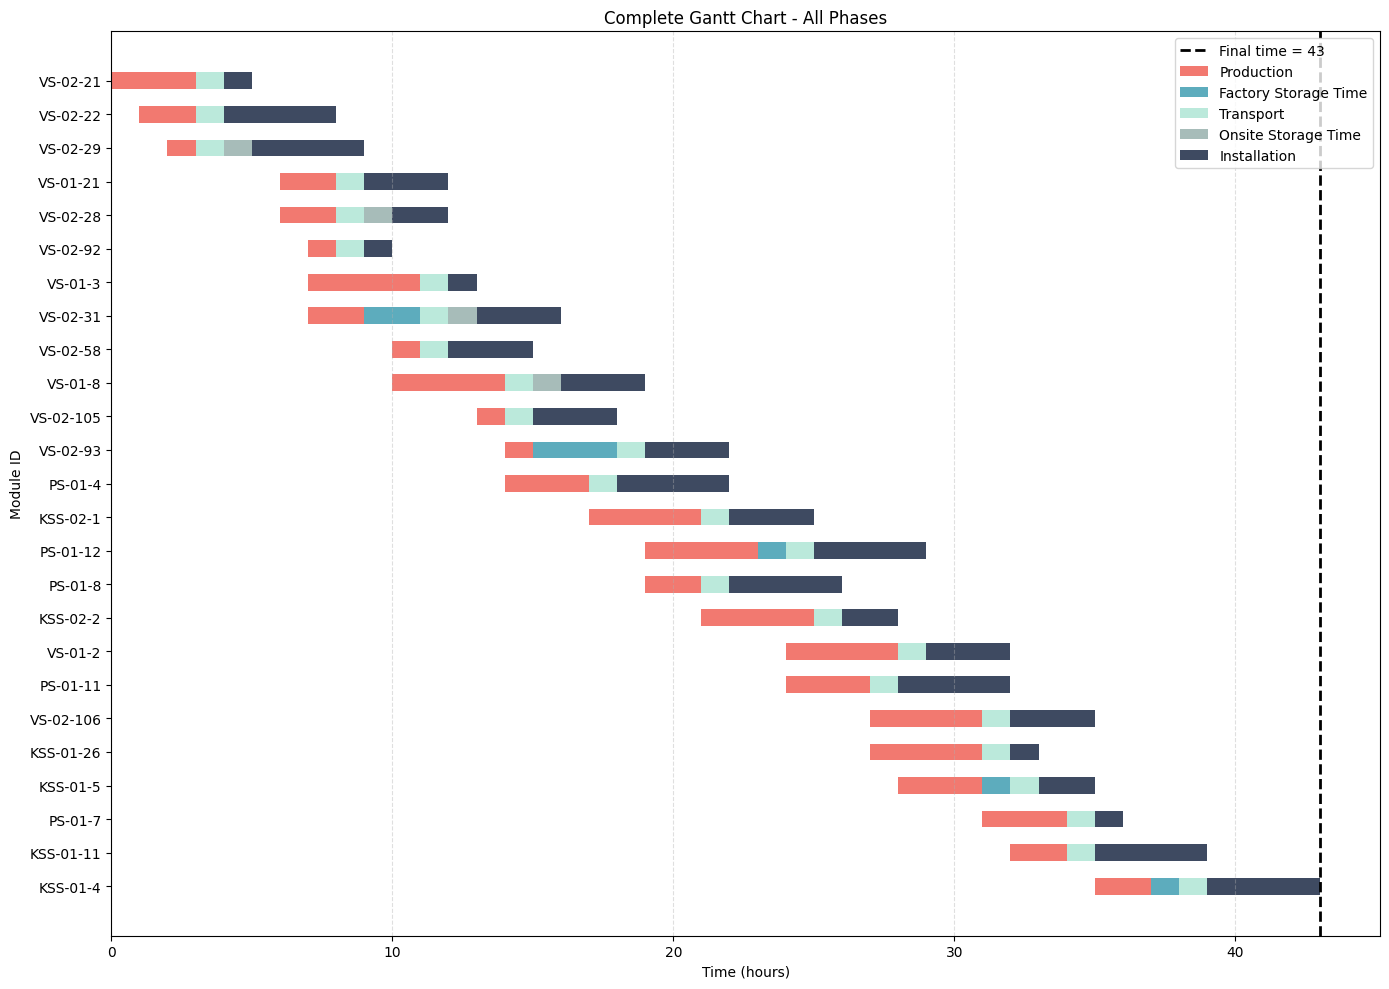

In [43]:
plot_gantt_from_solution_df(solution_df_0)


(np.int64(46),
 <Axes: title={'center': 'Complete Gantt Chart - All Phases'}, xlabel='Time (hours)', ylabel='Module ID'>)

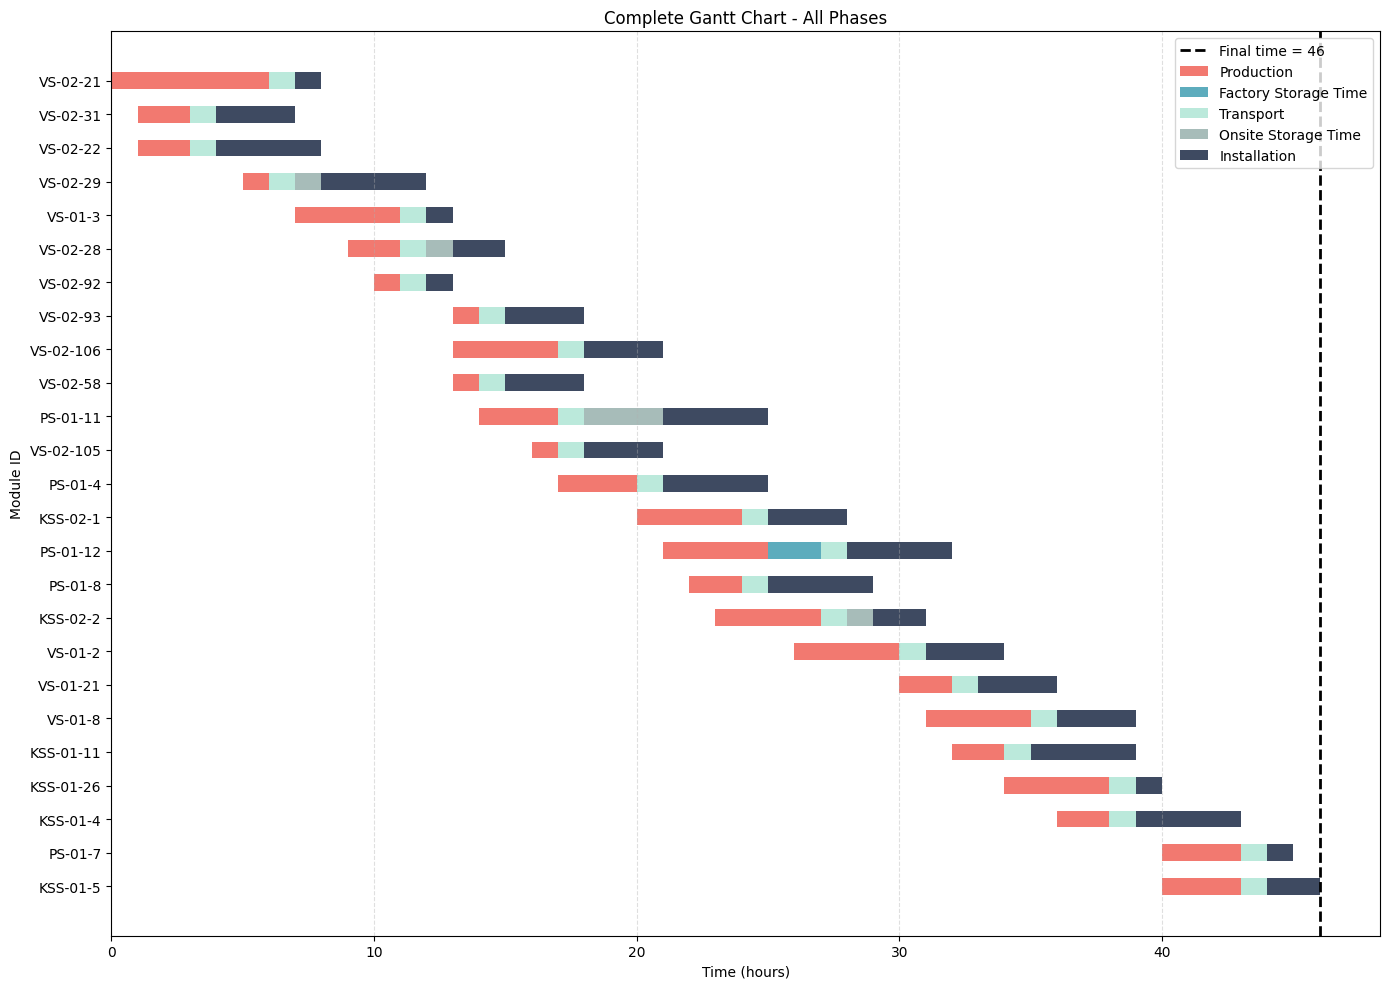

In [44]:
plot_gantt_from_solution_df(solution_df_1)

(np.int64(46),
 <Axes: title={'center': 'Complete Gantt Chart - All Phases'}, xlabel='Time (hours)', ylabel='Module ID'>)

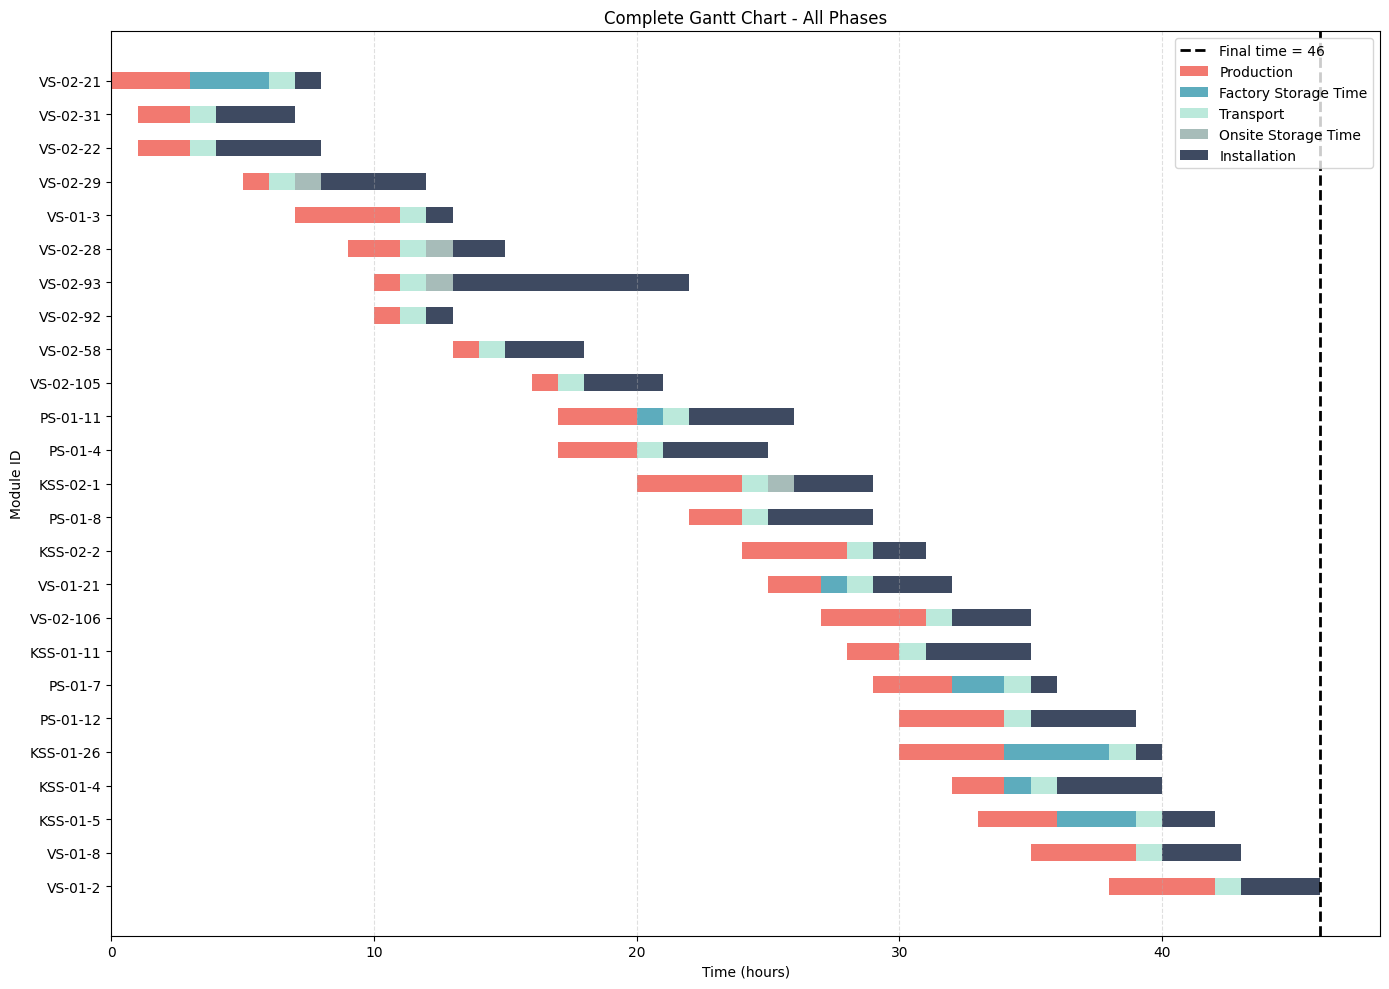

In [45]:
plot_gantt_from_solution_df(solution_df_2)

(np.int64(52),
 <Axes: title={'center': 'Complete Gantt Chart - All Phases'}, xlabel='Time (hours)', ylabel='Module ID'>)

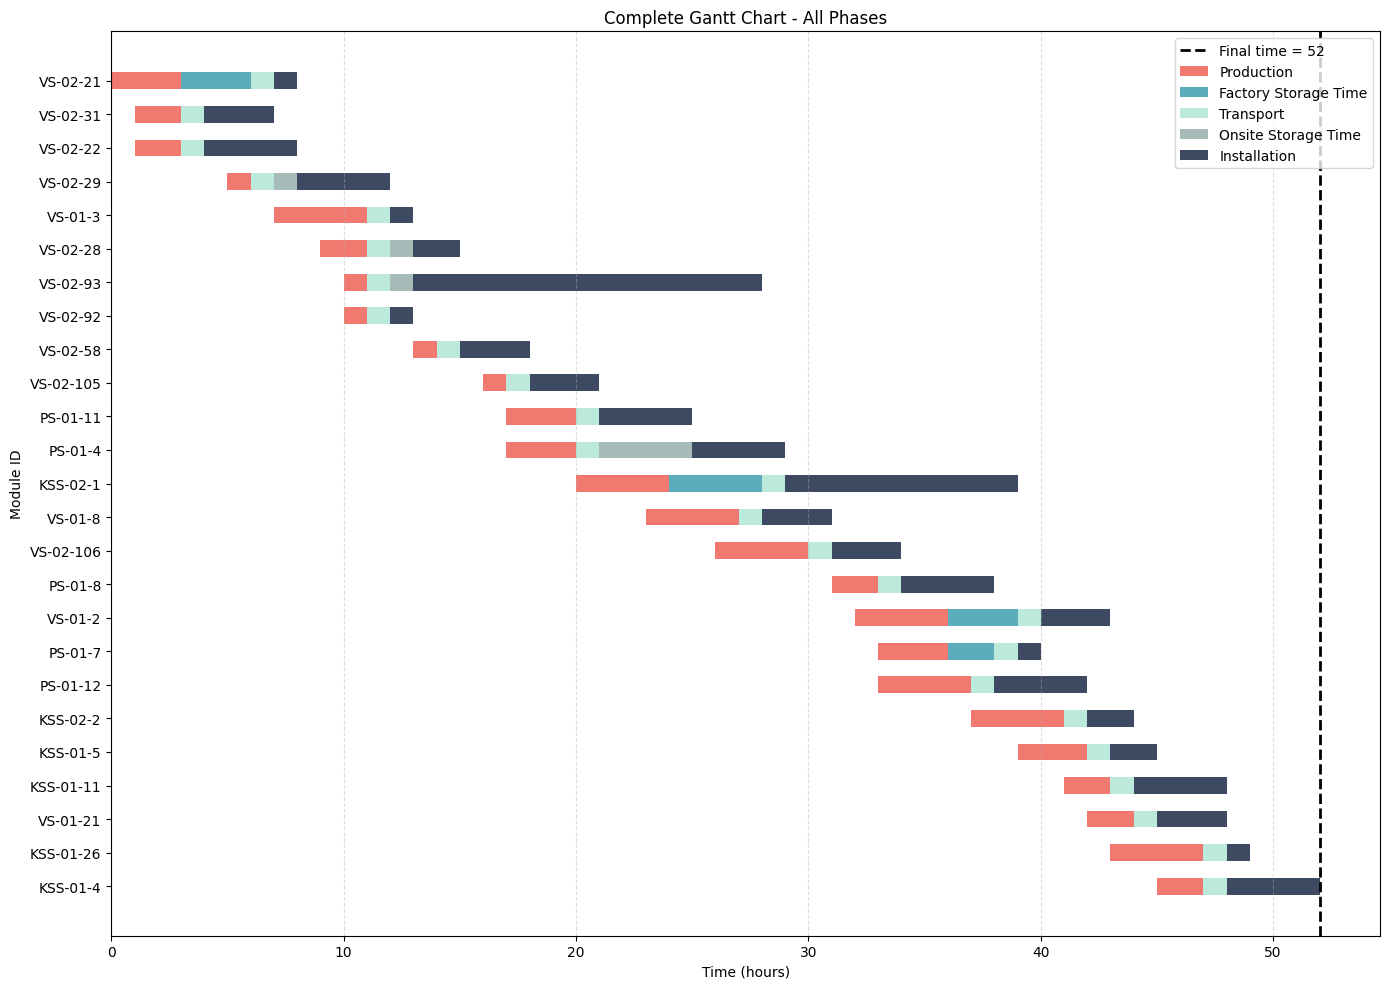

In [46]:
plot_gantt_from_solution_df(solution_df_3)